In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.animation import FuncAnimation
import matplotlib
import scipy.sparse as sps
from tqdm import tqdm,trange
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
# matplotlib.rcParams['figure.figsize'] = [8, 7]


In [56]:
import os
os.chdir(r'/Volumes/GoogleDrive/My Drive/Classroom/DTU/Special Course/Report/figures/Tdiff')


## Initializing the Mesh

In [57]:
domain_length = 1
meshsize = 100

dx = domain_length/meshsize*np.ones((meshsize))

x = np.ones((meshsize))
x[0] = dx[0]/2
for i in range(1,meshsize):
    x[i] = x[i-1] + dx[i-1]/2+dx[i]/2

## Entering phase diagram properties

In [58]:
c0 = 2.1

ceut = 4.2
calpha = 2.1

Tf = 1537
Teut = 1153

Tliq = (Teut-Tf)/ceut*c0 + Tf
Tsol = (Teut-Tf)/calpha*c0+Tf

kpar = calpha/ceut
T_init_cast = Tliq

c = c0*np.ones((meshsize))
cinit = c.copy()

def cl(T, Tf=Tf, ceut=ceut, Teut=Teut):
    return (T-Tf)*ceut/(Teut-Tf)

def TfromCl(cl, Tf=Tf, ceut=ceut, Teut=Teut):
    return cl/ceut*(Teut-Tf)+Tf

print(Tsol,Tliq)

1153.0 1345.0


## Simulating temperature diffusion

In [59]:
final_t = 2000

#Defining temperature as a function of time. Linear, no diffusion

def temp(time,Tsol=Tsol,Tliq=Tliq,tf=final_t):
    return Tliq + (Tsol-Tliq)*time/tf

def timeFromTemp(temp, Tsol=Tsol, Tliq=Tliq, tf=final_t):
    return (temp-Tliq)/(Tsol-Tliq)*tf

## diffusion_step

In [60]:
def diffusion_step(dx,c,dt,D,b1,b2,theta=1):
    
    meshsize = len(dx)
    r = np.zeros(meshsize)

    r[0] , r[meshsize-1] = 1/b1,1/b2
    r[1:meshsize-1] = dx[1:meshsize-1]/(2*D)
    
    hcon = np.zeros(meshsize)
    hcap = np.zeros(meshsize)

    for i in range(1, meshsize):
        hcon[i] = 1/(r[i-1]+r[i])

    for i in range(1, meshsize-1):
        hcap[i] = dx[i]/dt

    Att= calcAtt(hcon,hcap,theta=theta)
    At= calcAt(hcon,hcap,theta=theta)

    return np.linalg.inv(Att)@At@c

def calcAtt(hcon, hcap,theta):
    size = len(hcap)
    Att = np.zeros((size, size))
    for i in range(0, size):
        # Left boundary condition constant concentration
        if i == 0:
            Att[i][i] = 1
            continue
        # Right boundary condition constant concentration
        if i == size-1:
            Att[i][i] = 1
            continue
        Att[i][i-1] = -theta*hcon[i]
        Att[i][i] = hcap[i] + theta*hcon[i] + hcon[i+1]*theta
        Att[i][i+1] = -theta*hcon[i+1]
    return Att
    
def calcAt(hcon, hcap,theta):
    size = len(hcap)
    At = np.zeros((size, size))
    for i in range(0, size):
        #Left boundary condition
        if i == 0:
            At[i][i] = 1
            continue
        #Right boundary condition
        if i == size-1:
            At[i][i] = 1
            continue
        At[i][i-1] = (1-theta)*hcon[i]
        At[i][i] = hcap[i]-(1-theta)*hcon[i]-(1-theta)*hcon[i+1]
        At[i][i+1] = (1-theta)*hcon[i+1]
    return At

## Simulations

In [61]:
def simulateDiffTimestep(x,dx, c, steps,Dsol,Dliq,rateofchange,tol,fs_final=1, k=kpar,Tliq=Tliq,Tsol=Tsol):
    
    new_x = np.concatenate(([0],x,[x[-1]+dx[-1]]))

    length = np.sum(dx)

    meshsize = len(dx)
    c0 = np.average(c)
    c_initial = c.copy()
    
    T_old = Tliq
    t_init = Tliq-1E-6
    t_air = Tsol-300

    K_sol = 3000
    rho_sol = 7100
    cp_sol = 800

    K_liq = 3000
    rho_liq = 7100
    cp_liq = 800

    Hf = 1E5
    beta1 = 1E3

    Temp = t_init*np.ones((meshsize))

    concentrations = np.zeros((steps))

    t = 0
    
    Latent_Heat = 0
    profiles=[]

    #Total mass
    total_mass = length*c0

    #Guess initial dt
    dt = 1

    for inter in trange(round(fs_final*meshsize)):
        
        concentrations = c[inter]*np.ones((steps))

        #Declaring matrices
        new_c = np.zeros((meshsize))
        new_concentrations = np.zeros((steps))

        # Iterating over nodes
        for step in trange(steps):
            if inter==meshsize-1 and step ==steps-1:
                continue
            #Assemble arrays

            solid_steps_dx = dx[inter]/steps*np.ones((step+1))
            solid_steps_c = concentrations[:step+1]
            liq_steps_dx = dx[inter]/steps*np.ones((steps-(step+1)))
            liq_steps_c = concentrations[step+1:]
            solid_dx = np.concatenate(([dx[0]], dx[0:inter], solid_steps_dx, [dx[inter]/steps]))
            liq_dx = np.concatenate(([dx[inter]/steps], liq_steps_dx, dx[inter+1:], [dx[-1]]))

            #Declaring temperature properties
            Heat = np.zeros(meshsize+2)
            Heat[inter+1] = 1

            #### Iterative method
            change = 1
            dx_T = np.concatenate(([dx[0]],dx,[dx[-1]]))

            #Defining r
            r = np.zeros(len(dx_T))
            hcap = np.zeros((len(dx_T)))
            hcon = np.zeros((len(dx_T)))
            
            r[0] = 1/beta1
            r[-1] = 1/1E-16
            K_inter = (step*K_sol+(steps-step)*K_liq)/steps

            r[1:inter+1] = dx_T[1:inter+1]/(2*K_sol)
            r[inter+1] = dx_T[inter+1]/(2*K_inter)
            r[inter+2:-1] = dx_T[inter+2:-1]/(2*K_liq)

            hcon[1:] = 1/(r[0:-1]+r[1:])
            counter = 0
            while abs(change)>tol:
                counter+=1
                ######################################################
                #Solve Temperature

                hcap[:inter+1] = dx_T[0:inter+1]*rho_sol*cp_sol/dt

                # hcap[inter+1] = dx_T[inter+1]*rho_sol/dt*((cp_sol*step + cp_liq*(steps-step))/steps - Hf*dx[inter]/steps/(Temp[inter]-T_old))
                hcap[inter+1] = dx_T[inter+1]*rho_sol/dt*((cp_sol*step + cp_liq*(steps-step))/steps)
                
                hcap[inter+2:] = dx_T[inter+2:]*rho_liq*cp_liq/dt

                Att = calcAtt(hcon,hcap,theta=1)
                At = calcAt(hcon,hcap,theta=1)

                T_arr = np.concatenate(([t_air],Temp,[Temp[-1]]))
                
                new_Temp = np.linalg.inv(Att)@(At@T_arr + Heat*Hf*rho_liq*(dx[inter]/steps)/dt)
                # new_Temp = np.linalg.inv(Att)@(At@T_arr)

                # Interpolating to the Temperature
                new_Temp[0] = new_Temp[1]
                step_x = x[inter]-dx[inter]/2 + dx[inter]/steps/2+step*dx[inter]/steps
                
                func = interp1d(new_x,new_Temp)
                T = func(step_x)
                T = np.interp(step_x,new_x,new_Temp)

                new_Temp = new_Temp[1:-1]
                # T = np.average(new_Temp)
                
                ######################################################
                #Solve diffusion

                solid_c = np.concatenate(([c[0]], c[0:inter], solid_steps_c, [k*cl(T)]))
                solid_c[-2] = k*cl(T)
                liq_c = np.concatenate(([cl(T)], liq_steps_c, c[inter+1:], [c[-1]]))

                new_solid = diffusion_step(solid_dx,solid_c,dt,Dsol,1E-16,1E16)[1:-1] #Removing dead nodes
                new_liquid = diffusion_step(liq_dx,liq_c,dt,Dliq,1E16,1E-16)[1:-1] #Removing dead nodes

                ######################################################
                #Assemble final concentration
                
                new_c[0:inter] = new_solid[0:inter]
                new_c[inter+1:] = new_liquid[(steps-(step+1)):]

                new_concentrations[0:step+1] = new_solid[inter:]
                new_concentrations[step+1:] = new_liquid[0:(steps - (step+1))]
                
                new_c[inter] = np.average(new_concentrations)

                ######################################################
                # Finding change
                
                change = np.sum(dx*(new_c))-np.sum(dx*c_initial)

                dt = dt*(1-change/total_mass*rateofchange)

            Temp[inter] = T_old
            if step==steps-1:
                T_old = Temp[inter+1]

            # Latent_Heat += Hf*rho_liq*(length/steps/meshsize)
            liq_flux = (np.sum(new_concentrations[step+1:]) - np.sum(concentrations[step+1:]))*dx[inter]/steps + (np.sum(new_c[inter+1:])-np.sum(c[inter+1:]))*dx[0]

            Temp = new_Temp.copy()
            t= t+dt
            
            ## Updating the values using new interface

            mass_change = np.sum(dx*(new_c))-np.sum(dx*c_initial)

            concentrations = new_concentrations.copy()
            c = new_c.copy()

            profiles_dx = np.concatenate((solid_dx[1:-1],liq_dx[1:-1]))
            profiles_x = np.ones((len(profiles_dx)))
            profiles_x[0] = profiles_dx[0]/2
            for i in range(1,len(profiles_dx)):
                profiles_x[i] = profiles_x[i-1] + profiles_dx[i-1]/2+profiles_dx[i]/2
                
            profiles_c = np.concatenate((new_solid,new_liquid))
            
            profiles.append(((profiles_x.copy(),profiles_c.copy()), inter+step/steps,mass_change,t,concentrations.copy(),Temp.copy(),liq_flux))
    
    return profiles,0 #Latent_Heat/(Hf*rho_liq*length)


## Running simulation

In [62]:
Dsol = 1E-10
Dliq = 1E10
steps = 5

Simulation_result,Latent_Heat = simulateDiffTimestep(x.copy(),dx.copy(),c.copy(),steps,Dsol,Dliq,10,1E-5,fs_final=0.8)

100%|██████████| 80/80 [01:28<00:00,  1.11s/it]


In [63]:
profiles = [Simulation_result[i][0] for i in range(len(Simulation_result))]
profiles = np.array(profiles)
interface = [Simulation_result[i][1] for i in range(len(Simulation_result))]
interface = np.array(interface)
mass_change = [Simulation_result[i][2] for i in range(len(Simulation_result))]
time = [Simulation_result[i][3] for i in range(len(Simulation_result))]
time = np.array(time)
Temp = [Simulation_result[i][5]for i in range(len(Simulation_result))]
liq_flux = [Simulation_result[i][6]for i in range(len(Simulation_result))]
dt = [time[i+1]-time[i] for i in range(len(time)-1)]

print(len(profiles))

400


In [64]:
print(Latent_Heat)

0


Tf = 6022.2090743378 s


Text(0.5, 1.0, 'Time')

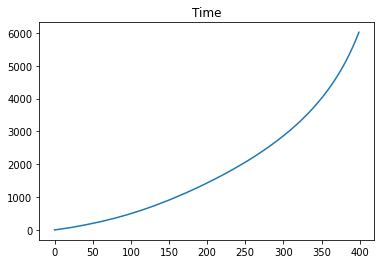

In [65]:
print("Tf = "+str(time[-1])+" s")
plt.plot(time)
plt.title('Time')

0.07444845365724105


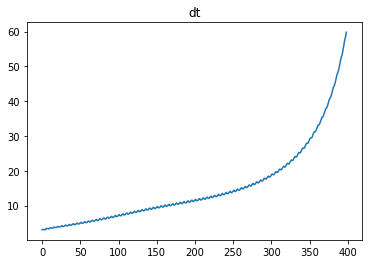

In [66]:
plt.plot(dt[:])
plt.title('dt')

print((dt[steps]-dt[0])/(dt[steps]))

In [67]:
fs = 1
index_f = int(fs*len(profiles))
# index = 12
@interact(index=(0,index_f-1))
def plot(index):
    plt.clf()
    plt.plot(profiles[index][0],profiles[index][1])
    plt.title('profile')
    
    # plt.ylim(np.min(profiles[0][1]),np.max(profiles[-1][1]))
    plt.show()

interactive(children=(IntSlider(value=199, description='index', max=399), Output()), _dom_classes=('widget-int…

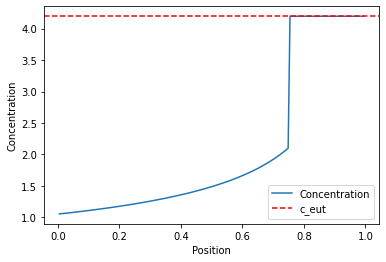

In [89]:
index = 374
plt.plot(profiles[index][0], profiles[index][1],label='Concentration')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.axhline(ceut,color='red',ls='--',label = 'c_eut')
plt.legend()
# plt.ylim(np.min(profiles[0][1]),np.max(profiles[-1][1]))
plt.savefig('Eut c.png',bbox_inches='tight',dpi=400)

In [68]:
fs = 1
index_f = int(fs*len(profiles))
# index = 12
@interact(index=(0,index_f-1))
def plot(index):
    plt.clf()
    plt.plot(Temp[index])
    plt.axhline(Tsol,label='Tsol',color='red')
    plt.axhline(Tliq,label='Tliq',color='green')
    plt.axvline(int(index/steps),color='orange',label='interface')
    plt.title('Temperature')
    plt.legend()
    # plt.ylim(Tsol-1,Tliq+1)
    plt.show()
print(np.average(Temp[-1]))

interactive(children=(IntSlider(value=199, description='index', max=399), Output()), _dom_classes=('widget-int…

1095.7945346065048


374


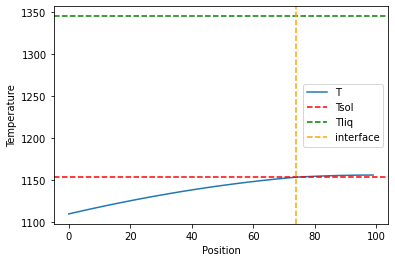

In [90]:
for i in range(len(Temp)):
    if abs(Temp[i][int(i/steps)]-Tsol)<1:
        index = i
        break
plt.plot(Temp[index],label = 'T')
plt.axhline(Tsol, label='Tsol', color='red',ls = '--')
plt.axhline(Tliq, label='Tliq', color='green',ls = '--')
plt.axvline(int(index/steps), color='orange', label='interface',ls = '--')
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.legend()
print(i)
# plt.ylim(Tsol-10,Tliq+10)
# plt.savefig('Scheil full latent.png',bbox_inches='tight',dpi=400)
plt.savefig('Eut T.png', bbox_inches='tight', dpi=400)


Text(0.5, 1.0, 'dm vs t')

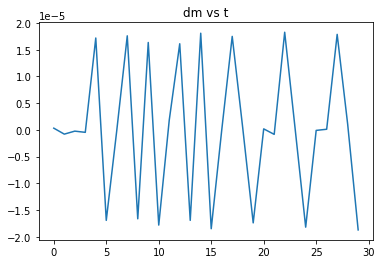

In [70]:
dm = [mass_change[i+1]-mass_change[i] for i in range(len(mass_change)-1)]
plt.plot(dm[:30])
plt.title('dm vs t')

-9.967736100513491e-06


Text(0.5, 1.0, 'Mass Change vs time')

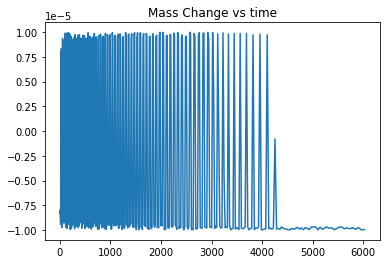

In [71]:
plt.plot(time,mass_change)
print(mass_change[-1])
plt.title('Mass Change vs time')

[7272215.82416098]
0.8972064716015408


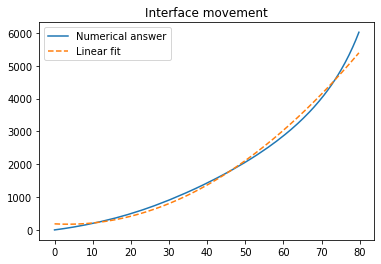

In [72]:
plt.plot(interface,time)
plt.title('Interface movement')

params = np.polyfit(interface,time,2,full=True)
V = params[0][0]
error = params[1]
plt.plot(interface,params[0][2]+interface*params[0][1]+interface*interface*params[0][0],'--')
plt.legend(['Numerical answer','Linear fit'])
print(error)
print(params[0][0])

## Brody Flemings

In [73]:
alpha = Dsol/(domain_length*V)
fs = interface/meshsize

In [74]:
Cs_brody = kpar*c0*(1-(1-2*alpha*kpar)*fs)**((kpar-1)/(1-2*alpha*kpar))
cs_ana= np.zeros((len(interface)))
for i in range(len(interface)):
    index = interface[i]*steps - int(interface[i])*(steps-1)
    index= int(index)
    cs_ana[i] = profiles[i,1,index]

Text(0, 0.5, 'cs')

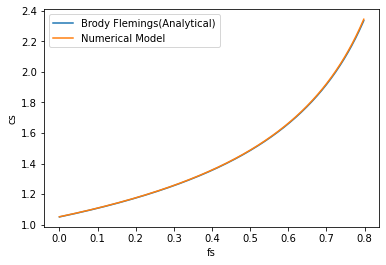

In [75]:
plt.plot(fs,Cs_brody)
plt.plot(fs,cs_ana)
plt.legend(['Brody Flemings(Analytical)','Numerical Model'])
plt.xlabel('fs')
plt.ylabel('cs')

Text(0, 0.5, 'cs')

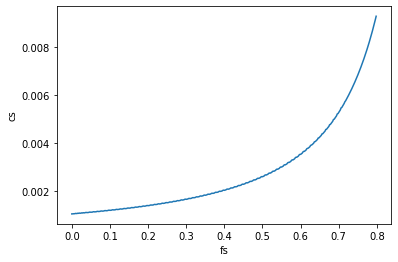

In [76]:
plt.plot(fs,cs_ana-Cs_brody)
plt.xlabel('fs')
plt.ylabel('cs')